# Sentiment Analysis on IMDB dataset of movie reviews.
### Machine Learning Project(CSE 6363)  created by-
### 1. Karan Vasudevamurthy
### 2. Suraj Kalyaudimpudi
### 3. Sai Krishna Movva Jaya

## Importing the libraries

In [15]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout, SpatialDropout1D,
    Bidirectional, BatchNormalization
)
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import re

## Loading the dataset

In [16]:
nltk.download('stopwords')

# Load Dataset
train_df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
print("The Shape of the Dataset: ", train_df.shape)
print(train_df.head())

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
The Shape of the Dataset:  (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


## Exploratory Data Analysis

Total Counts of both sets sentiment
positive    25000
negative    25000
Name: count, dtype: int64


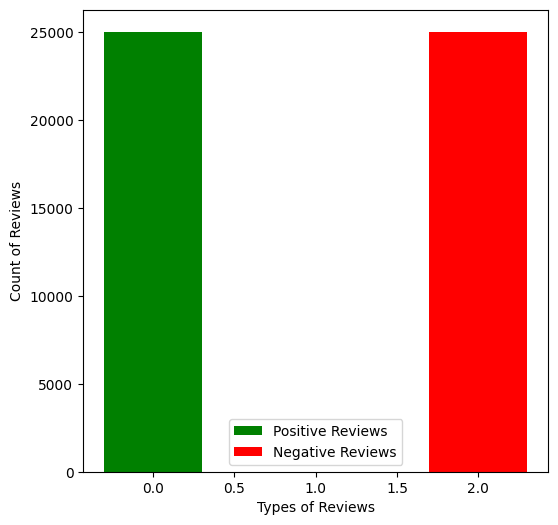

In [17]:
count=train_df['sentiment'].value_counts()
print('Total Counts of both sets'.format(),count)

print("==============")
#Creating a function to plot the counts using matplotlib
def plot_counts(count_good,count_bad):
    plt.rcParams['figure.figsize']=(6,6)
    plt.bar(0,count_good,width=0.6,label='Positive Reviews',color='Green')
    plt.legend()
    plt.bar(2,count_bad,width=0.6,label='Negative Reviews',color='Red')
    plt.legend()
    plt.ylabel('Count of Reviews')
    plt.xlabel('Types of Reviews')
    plt.show()

count_good=train_df[train_df['sentiment']=='positive']
count_bad=train_df[train_df['sentiment']=='negative']
plot_counts(len(count_good),len(count_bad))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


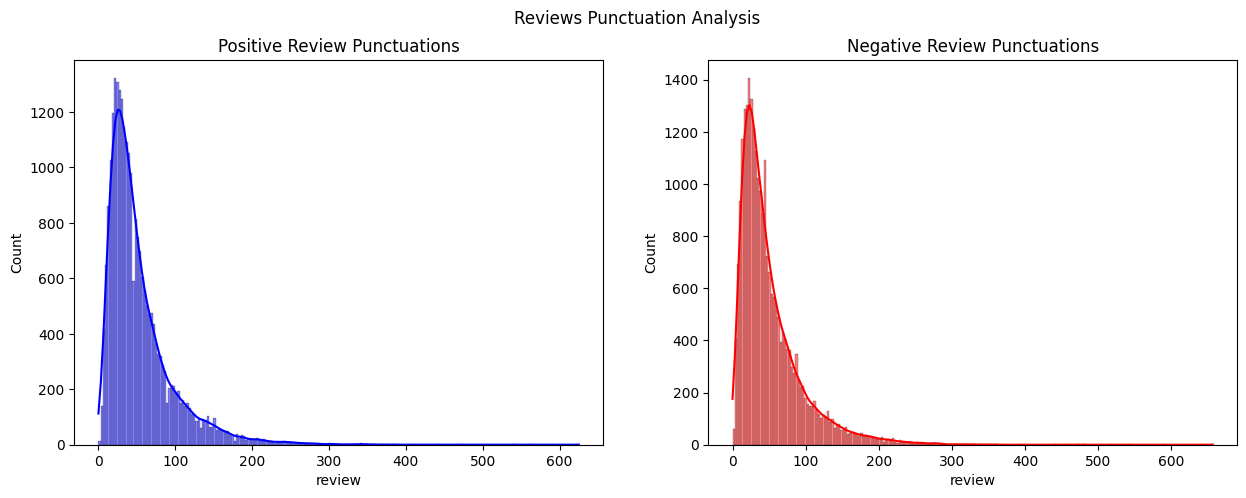

In [9]:
# Count punctuations
count_good_punctuations = count_good['review'].apply(lambda z: len([c for c in str(z) if c in string.punctuation]))
count_bad_punctuations = count_bad['review'].apply(lambda z: len([c for c in str(z) if c in string.punctuation]))
#Plotting
def plot_count(count_ones, count_zeros, title_1, title_2, subtitle):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(count_zeros, ax=ax1, color='Blue', kde=True)
    ax1.set_title(title_1)
    sns.histplot(count_ones, ax=ax2, color='Red', kde=True)
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()

plot_count(
    count_good_punctuations,
    count_bad_punctuations,
    "Positive Review Punctuations",
    "Negative Review Punctuations",
    "Reviews Punctuation Analysis"
)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


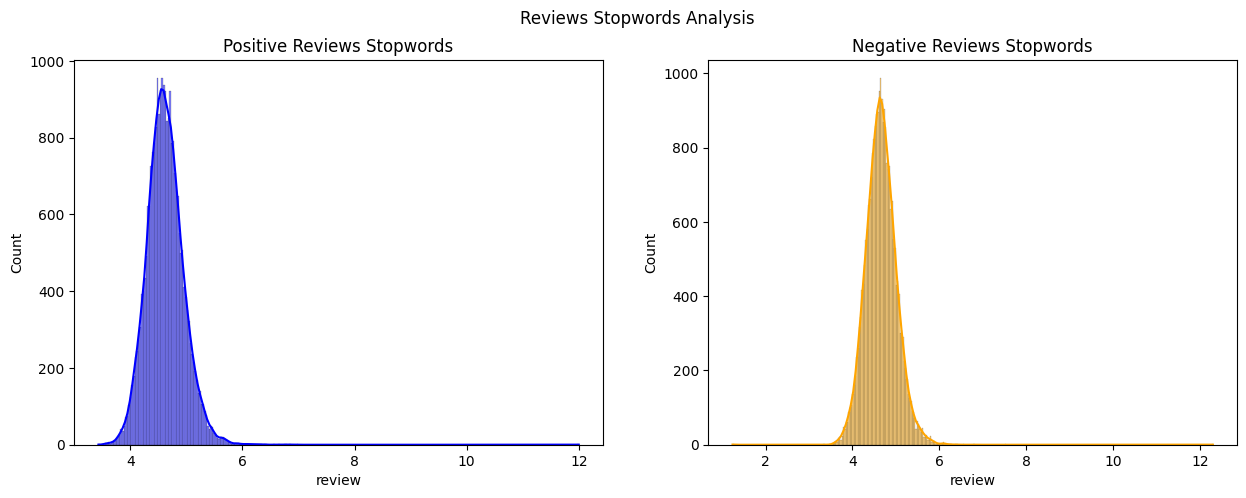

In [18]:
# Calculate mean word length in positive and negative reviews
count_good_stops = count_good['review'].apply(lambda z: np.mean([len(w) for w in str(z).split()]))
count_bad_stops = count_bad['review'].apply(lambda z: np.mean([len(w) for w in str(z).split()]))

# Plot stopwords analysis using Seaborn
def plot_count_1(count_ones, count_zeros, title_1, title_2, subtitle):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(count_zeros, ax=ax1, color='Blue', kde=True)
    ax1.set_title(title_1)
    sns.histplot(count_ones, ax=ax2, color='Orange', kde=True)
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()

plot_count_1(
    count_good_stops,
    count_bad_stops,
    "Positive Reviews Stopwords",
    "Negative Reviews Stopwords",
    "Reviews Stopwords Analysis"
)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


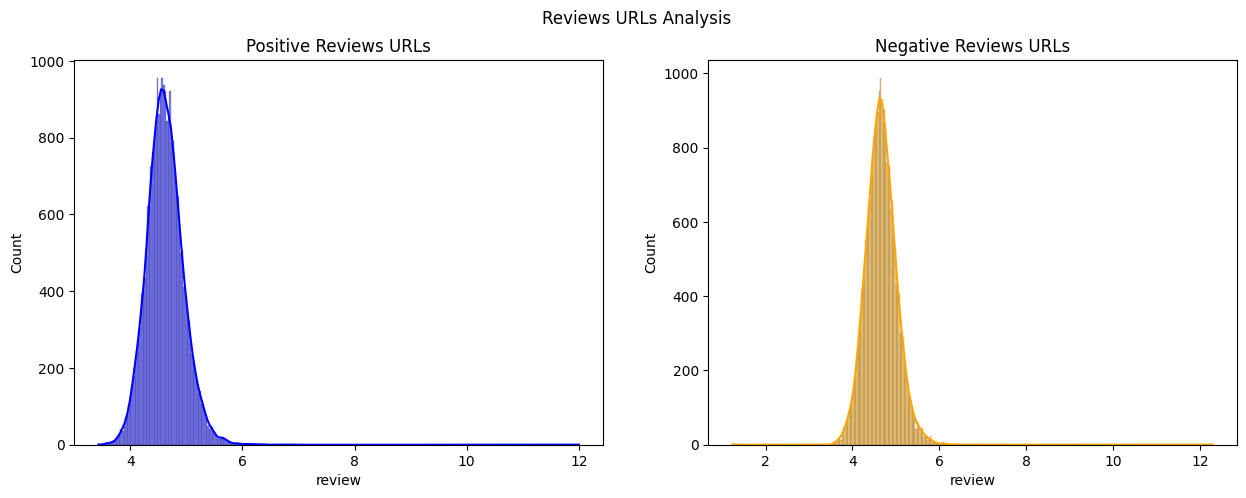

In [11]:
# Count URLs in positive and negative reviews
count_good_urls=count_good['review'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
count_bad_urls=count_bad['review'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

plot_count_1(count_good_stops,count_bad_stops,"Positive Reviews URLs","Negative Reviews URLs","Reviews URLs Analysis")

## Pre Processingtaset.

In [19]:
def remove_punctuations(data):
    return re.sub(r'[^\w\s]', '', data)

def remove_html(data):
    return re.sub(r'<.*?>', '', data)

def remove_url(data):
    return re.sub(r"https?://\S+|www\.\S+", '', data)

def remove_emoji(data):
    return re.sub(
        "[" u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"      # symbols & pictographs
        u"\U0001F680-\U0001F6FF"      # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"      # flags (iOS)
        "]+", '', data)

def remove_stopwords(data):
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in data.split() if word.lower() not in stop_words]
    return " ".join(filtered_words)

In [20]:
train_df['review'] = train_df['review'].apply(remove_html)
train_df['review'] = train_df['review'].apply(remove_url)
train_df['review'] = train_df['review'].apply(remove_emoji)
train_df['review'] = train_df['review'].apply(remove_punctuations)
train_df['review'] = train_df['review'].apply(remove_stopwords)
train_df['sentiment'] = train_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

print(train_df.head())

                                              review  sentiment
0  One reviewers mentioned watching 1 Oz episode ...          1
1  wonderful little production filming technique ...          1
2  thought wonderful way spend time hot summer we...          1
3  Basically theres family little boy Jake thinks...          0
4  Petter Matteis Love Time Money visually stunni...          1


## Tokenization and Padding

In [21]:
X = train_df['review'].values
y = train_df['sentiment'].values

tokenizer = Tokenizer(num_words=10000)  # Increased to top 10,000 words for richer vocabulary
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

# Set padding length to median of sequence lengths
max_len = int(np.median([len(seq) for seq in X]))
X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')

## Train - Test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Glove embeddings

In [23]:
embedding_dim = 100
embedding_index = {}
glove_path = "/kaggle/input/glove6b100dtxt/glove.6B.100d.txt"

with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefs

vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Model Defn

In [17]:
model = Sequential()
model.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True,  # Fine-tune embeddings
    )
)
model.add(SpatialDropout1D(0.4))  # Increased dropout for regularization
model.add(
    LSTM(
        128, return_sequences=True, dropout=0.4, recurrent_dropout=0.3,
        kernel_regularizer=l2(1e-4)
    )
)
model.add(BatchNormalization())
model.add(
    LSTM(
        64, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=l2(1e-4)
    )
)
model.add(Dense(64, activation="relu", kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

# Compile Model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    22,157,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,157,100 (84.52 MB)

 Trainable params: 22,157,100 (84.52 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

In [19]:
batch_size = 64
epochs = 10
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size,
    validation_data=(X_test, y_test), verbose=1,
    callbacks=[lr_scheduler]
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 110s 164ms/step - accuracy: 0.5344 - loss: 0.7378 - val_accuracy: 0.4965 - val_loss: 0.7356 - learning_rate: 0.0010
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 102s 163ms/step - accuracy: 0.6464 - loss: 0.6657 - val_accuracy: 0.8343 - val_loss: 0.4219 - learning_rate: 0.0010
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 102s 163ms/step - accuracy: 0.7994 - loss: 0.4862 - val_accuracy: 0.8505 - val_loss: 0.3782 - learning_rate: 0.0010
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 102s 163ms/step - accuracy: 0.8353 - loss: 0.4196 - val_accuracy: 0.8655 - val_loss: 0.3498 - learning_rate: 0.0010
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 102s 163ms/step - accuracy: 0.8523 - loss: 0.3862 - val_accuracy: 0.8701 - val_loss: 0.3429 - learning_rate: 0.0010
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 103s 164ms/step - accuracy: 0.8629 - loss: 0.3582 - val_accuracy: 0.8735 - val_loss: 0.3315 - learning_rate: 0.0010
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 102s 163ms/step - accura

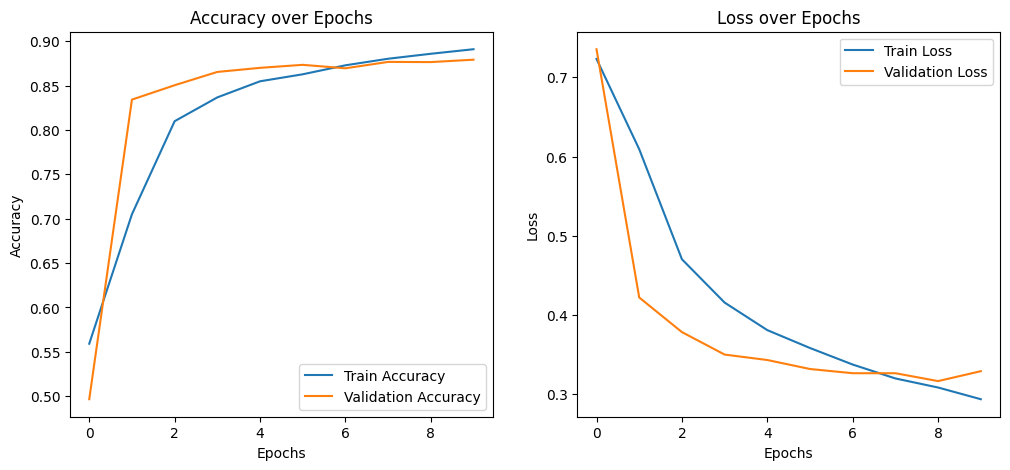

In [20]:
# Plot accuracy and loss over epochs
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [21]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Thresholding to get binary predictions

313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step


In [22]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[4400  561]
 [ 646 4393]]


In [23]:
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

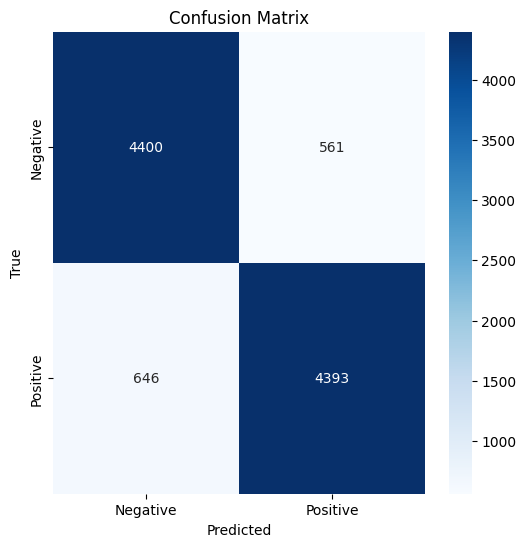

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      4961
           1       0.89      0.87      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Test Accuracy: 87.93%


In [24]:
plot_confusion_matrix(cm, labels=['Negative', 'Positive'])

# Classification Report (Precision, Recall, F1, etc.)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [30]:
from keras.callbacks import EarlyStopping

model = Sequential()

# Embedding layer
model.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True,  # Fine-tune embeddings
    )
)

model.add(SpatialDropout1D(0.5))  # Increased dropout

# First Bidirectional LSTM Layer
model.add(
    Bidirectional(
        LSTM(
            64, return_sequences=True, dropout=0.5, recurrent_dropout=0.4,
            kernel_regularizer=l2(1e-4)
        )
    )
)
model.add(BatchNormalization())

# Second Bidirectional LSTM Layer (Reduced size)
model.add(
    Bidirectional(
        LSTM(
            32, dropout=0.5, recurrent_dropout=0.4, kernel_regularizer=l2(1e-4)
        )
    )
)

# Dense Layer with L2 Regularization
model.add(Dense(64, activation="relu", kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))  # Increased dropout

# Output Layer
model.add(Dense(1, activation="sigmoid"))

# Compile Model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with validation split and early stopping
model.summary()

# Fit model with early stopping and validation data
model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stopping])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │    22,157,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,157,100 (84.52 MB)

 Trainable params: 22,157,100 (84.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 129s 239ms/step - accuracy: 0.5232 - loss: 0.7598 - val_accuracy: 0.6944 - val_loss: 0.6489
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 120s 241ms/step - accuracy: 0.6400 - loss: 0.6911 - val_accuracy: 0.7961 - val_loss: 0.5389
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 121s 241ms/step - accuracy: 0.7393 - loss: 0.5881 - val_accuracy: 0.8299 - val_loss: 0.4743
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 120s 239ms/step - accuracy: 0.7961 - loss: 0.5066 - val_accuracy: 0.8431 - val_loss: 0.4179
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 119s 239ms/step - accuracy: 0.8222 - loss: 0.4522 - val_accuracy: 0.8550 - val_loss: 0.4276
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 119s 238ms/step - accuracy: 0.8344 - loss: 0.4251 - val_accuracy: 0.8600 - val_loss: 0.3798
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 119s 238ms/step - accuracy: 0.8700 - loss: 0.3543 - val_accuracy: 0.8714 - val_loss: 0.3730
Epoch 11/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 119s 239ms/step - accuracy: 0.8740 

In [36]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Thresholding to get binary predictions

313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step


In [37]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[4171  790]
 [ 499 4540]]


In [38]:
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

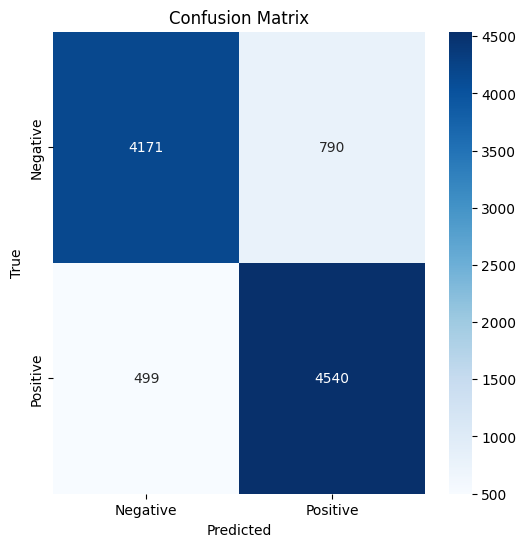

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.87      4961
           1       0.85      0.90      0.88      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Test Accuracy: 87.11%


In [39]:
plot_confusion_matrix(cm, labels=['Negative', 'Positive'])

# Classification Report (Precision, Recall, F1, etc.)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [2]:
import os
import re
import pandas as pd
import torch
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from datasets import Dataset
import wandb

In [3]:
# Initialize WandB
wandb.init(project="gpu-bert-sentiment")

nltk.download("stopwords")
from nltk.corpus import stopwords

# Global Parameters
STOPWORDS = set(stopwords.words("english"))


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def compute_metrics(pred):
    """Custom metric function for evaluation."""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = (preds == labels).mean()

    # Log metrics to WandB
    wandb.log({"eval_precision": precision, "eval_recall": recall, "eval_f1": f1, "eval_accuracy": acc})
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [6]:
def preprocess_text(text):
    """Clean and preprocess text."""
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    text = re.sub(r"https?://\S+|www\.\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = " ".join([word for word in text.split() if word.lower() not in STOPWORDS])  # Remove stopwords
    return text

In [7]:
# Load Dataset
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df["sentiment"] = df["sentiment"].apply(lambda x: 1 if x == "positive" else 0)
df["review"] = df["review"].apply(preprocess_text)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["review"].tolist(), df["sentiment"].tolist(), test_size=0.2, random_state=42
)

In [8]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels}).map(tokenize_function, batched=True)
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels}).map(tokenize_function, batched=True)


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [10]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=1e-4,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to="wandb",
    fp16=True,  # Enable mixed-precision training for faster training on GPUs
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [13]:
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.222200,0.234123,0.911200,0.932306,0.888271,0.909756
2,0.228900,0.272585,0.919700,0.927361,0.912086,0.919660
3,0.070700,0.374923,0.918600,0.924623,0.912880,0.918714


TrainOutput(global_step=7500, training_loss=0.18670813022156557, metrics={'train_runtime': 6572.5104, 'train_samples_per_second': 18.258, 'train_steps_per_second': 1.141, 'total_flos': 3.15733266432e+16, 'train_loss': 0.18670813022156557, 'epoch': 3.0})

Validation Accuracy: 0.9112
Validation Precision: 0.9323
Validation Recall: 0.8883
Validation F1 Score: 0.9098


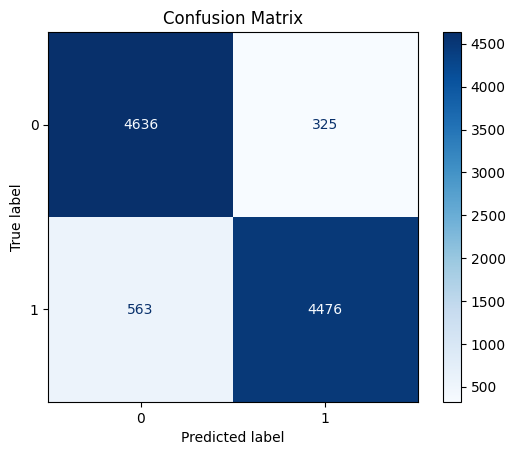

eval/accuracy,▁█▇▁
eval/f1,▁█▇▁
eval/loss,▁▃█▁
eval/precision,█▃▁█
eval/recall,▁██▁
eval/runtime,▆▁█▁
eval/samples_per_second,▃█▁█
eval/steps_per_second,▂█▁█
eval_accuracy,▁█▇▁▁
eval_f1,▁█▇▁▁
eval_precision,█▃▁██


<Figure size 640x480 with 0 Axes>

In [14]:
results = trainer.evaluate()

# Print evaluation metrics
print(f"Validation Accuracy: {results['eval_accuracy']:.4f}")
print(f"Validation Precision: {results['eval_precision']:.4f}")
print(f"Validation Recall: {results['eval_recall']:.4f}")
print(f"Validation F1 Score: {results['eval_f1']:.4f}")

# Predictions and Confusion Matrix
predictions = trainer.predict(val_dataset)
y_pred = predictions.predictions.argmax(axis=-1)
y_true = predictions.label_ids

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Log final metrics and confusion matrix to WandB
wandb.log({"confusion_matrix": wandb.Image(plt)})
wandb.finish()
